In [1]:
import numpy as np
from tools import *
from fitters import *
from plots import *
from projectors import *
sns.set_style('white')
plt.rcParams['figure.dpi'] = 300
%load_ext autoreload
%autoreload 2


In [2]:

n_series = 8
series_rank = 3
shape = (n_series, series_rank)

a_s = np.array([0.01, 1.0, 0.2]) #* np.sign(np.random.uniform(-1, 1, size=shape))
e_s = np.array([1.8, -0.8, -0.15])

noise = 1e-4
beta = 1e-5
start_end = (0, 3)
dt = 0.03
dim = 14

offset = True
time = np.arange(start_end[0], start_end[1]+dt, dt)

X0s = []
Xps = []
X_series_s, Y_series_s = [], []

for i in range(n_series):

    X_series, Y_series, _, _ = build_exp_series(
        a_s* np.sign(np.random.uniform(-1, 1, size=1)), e_s, noise=noise, time=time)
    if len(X_series_s) > 0:
        shift = X_series_s[-1][-1]-X_series[0]
        X_series += shift
        Y_series += shift
    X_series = X_series[1:]
    Y_series = Y_series[1:]
    X_series_s.append(X_series)
    Y_series_s.append(Y_series)

X_series = np.concatenate(X_series_s)
Y_series = np.concatenate(Y_series_s)

window = int(dim*3.0)

P_series_nowin, theta_nowin, A, c = eig_companion_Cshift(
    X_series, dim, beta=beta)
P_series_win, theta_win, ws = eig_companion_Cshift_time(
    X_series, dim, beta=beta, return_vals=True, window_size=window)

w, vl, vr = scipy.linalg.eig(A, left=True, right=True)
sortorder = np.argsort(np.abs(w.real))
thetas = vl[:, sortorder][:, ::-1]
w = w[sortorder][::-1]

# compute lams
max_es = e_s[:n_series].flatten()
lams = np.exp(max_es*dt)
lams = np.sort(lams)[::-1]
no_window_ev = [w[0].real]
true_lam = lams[0]

window_ev = ws[:, 0]
window_drop_ev = window_ev[np.abs(window_ev.imag) < 0.01]



In [3]:
window_ev.shape, window_drop_ev.shape

((758,), (658,))

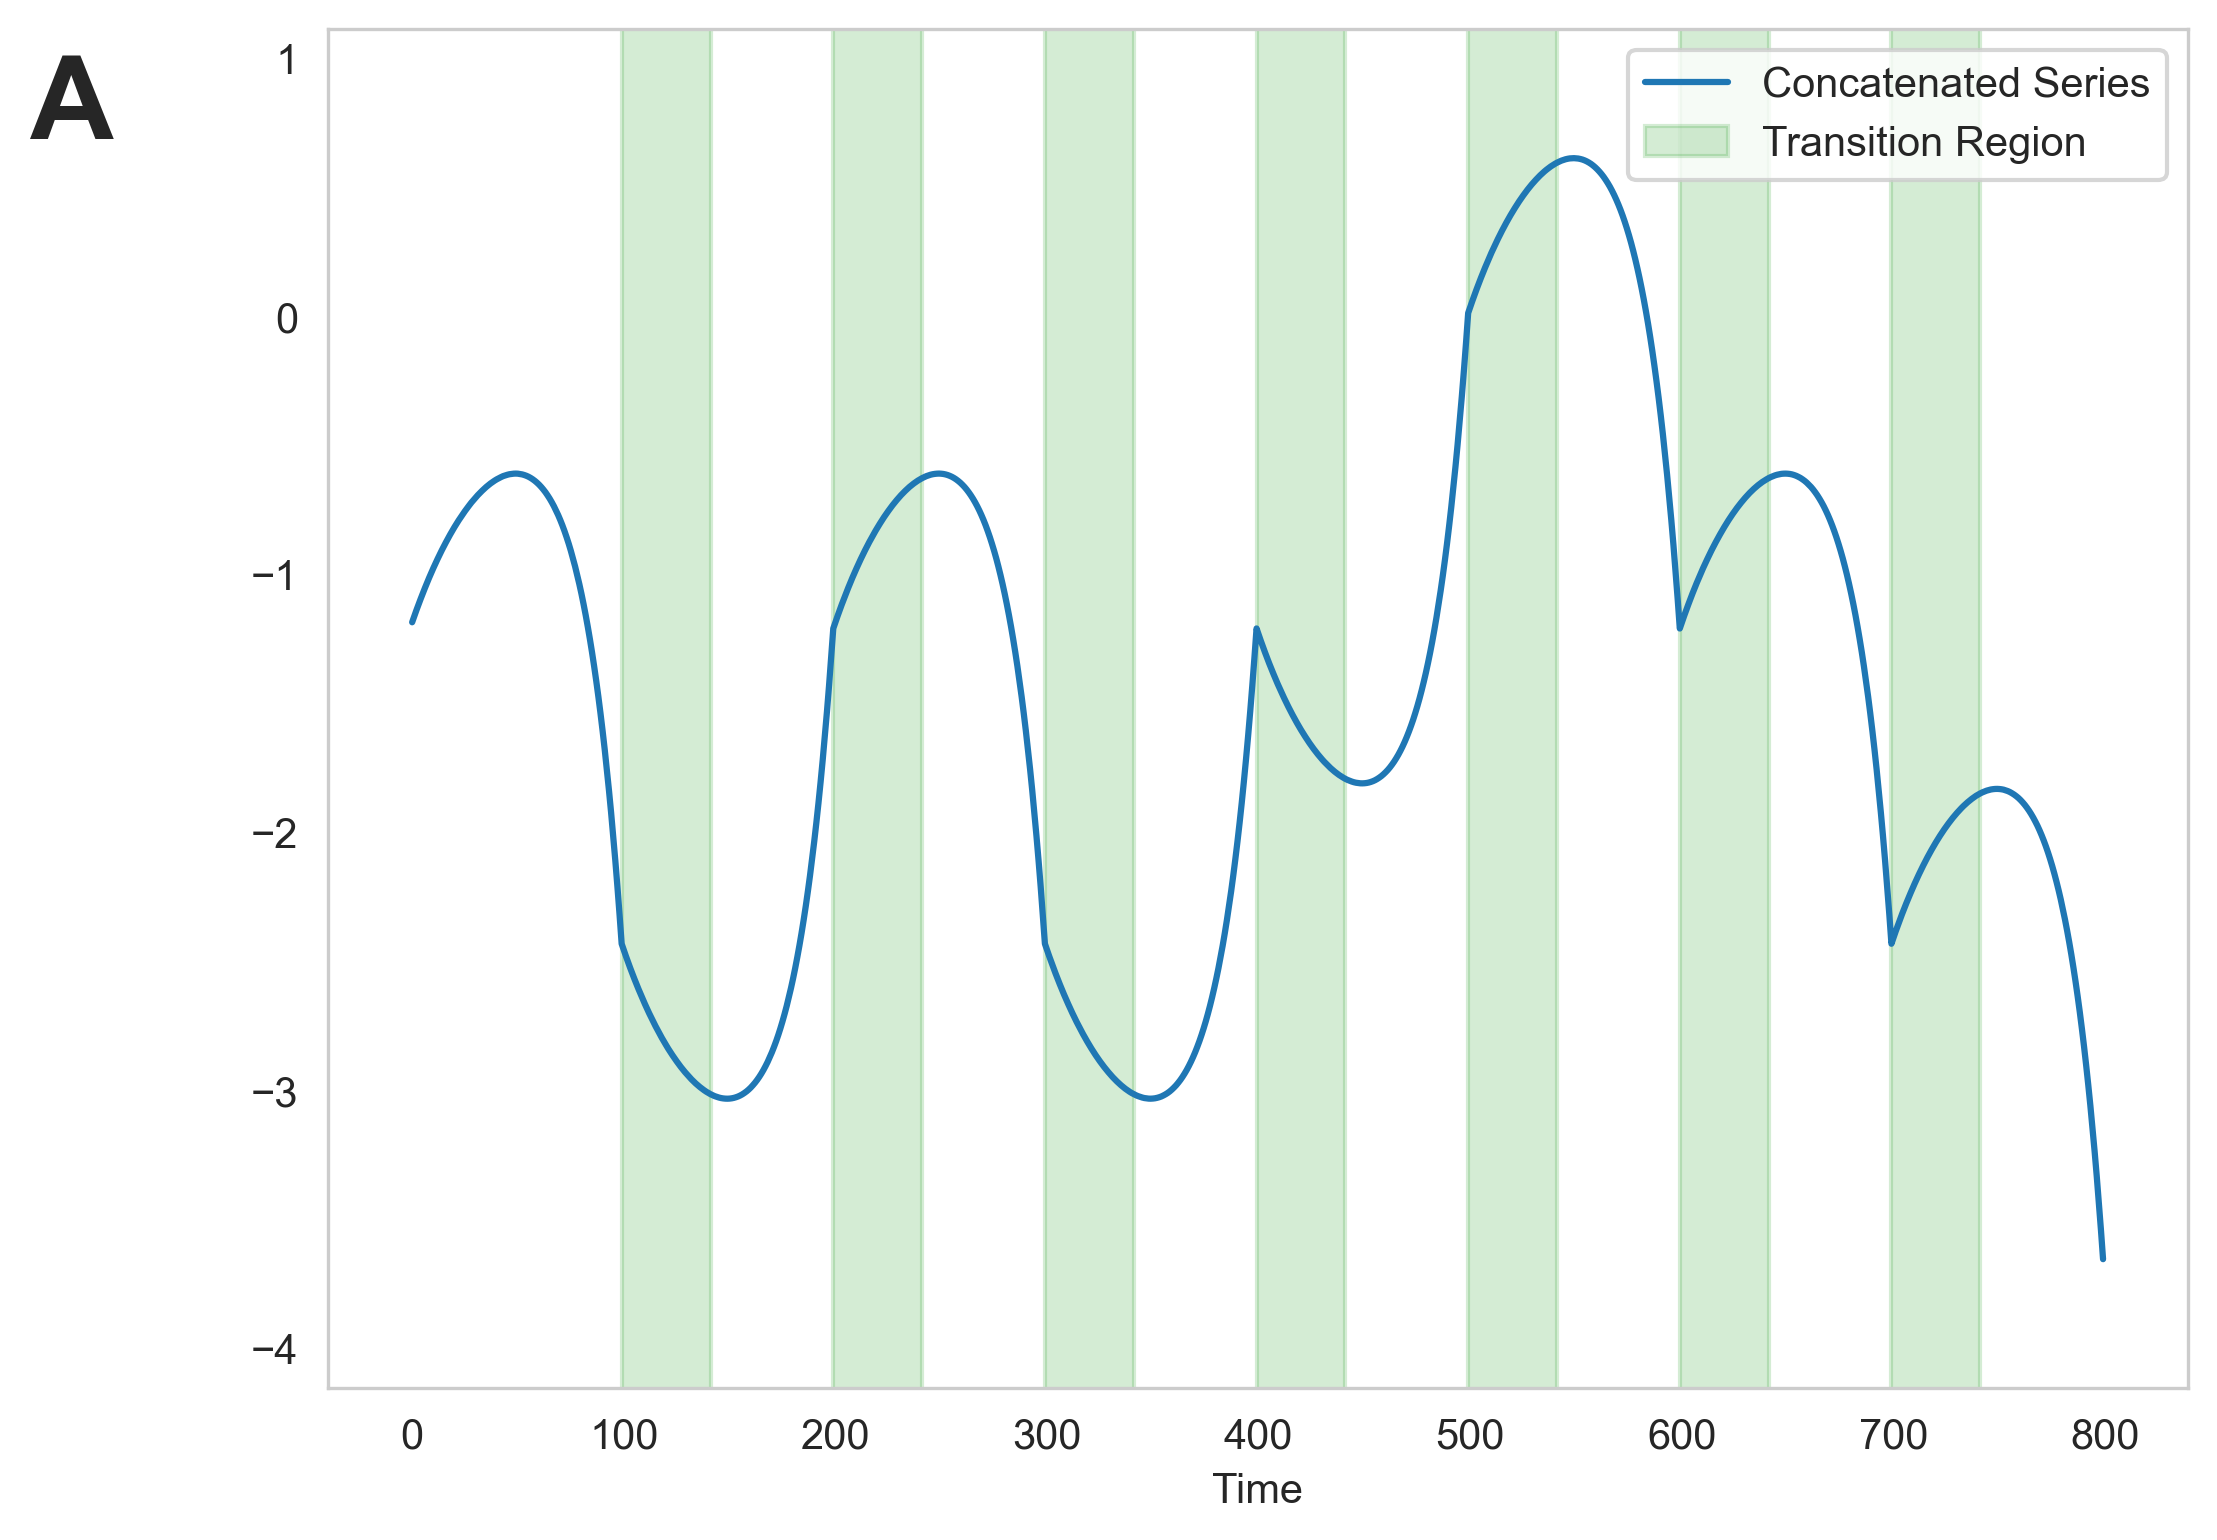

In [18]:
fig, ax = plt.subplots(1, 1)
ax.plot(X_series, label='Concatenated Series')
# ax.fill_between([len(time)*1-window-1-2,len(time)*1-2],-10000, 10000,alpha=0.2, label='Intermediate Region', color='tab:pink')
# [ax.fill_between([len(time)*n-window-n-1,len(time)*n-n-1],-10000, 10000,alpha=0.2, color='tab:pink') for n in range(2,n_series)]
ax.fill_between([len(time)-2,len(time)-2+window],-10000, 10000,alpha=0.2, label='Transition Region', color='tab:green')
[ax.fill_between([len(time)*n-n-1,len(time)*n-n-1+window],-10000, 10000,alpha=0.2, color='tab:green') for n in range(2,n_series)]
ax.set_xlabel('Time')
ax.set_ylim(X_series.min()-0.5,X_series.max()+.5)
plt.legend()
plt.text(-.16, .92, 'A', fontweight='bold', fontsize='28', transform=plt.gca().transAxes)
fig.set_size_inches(8, 6)
plt.show()


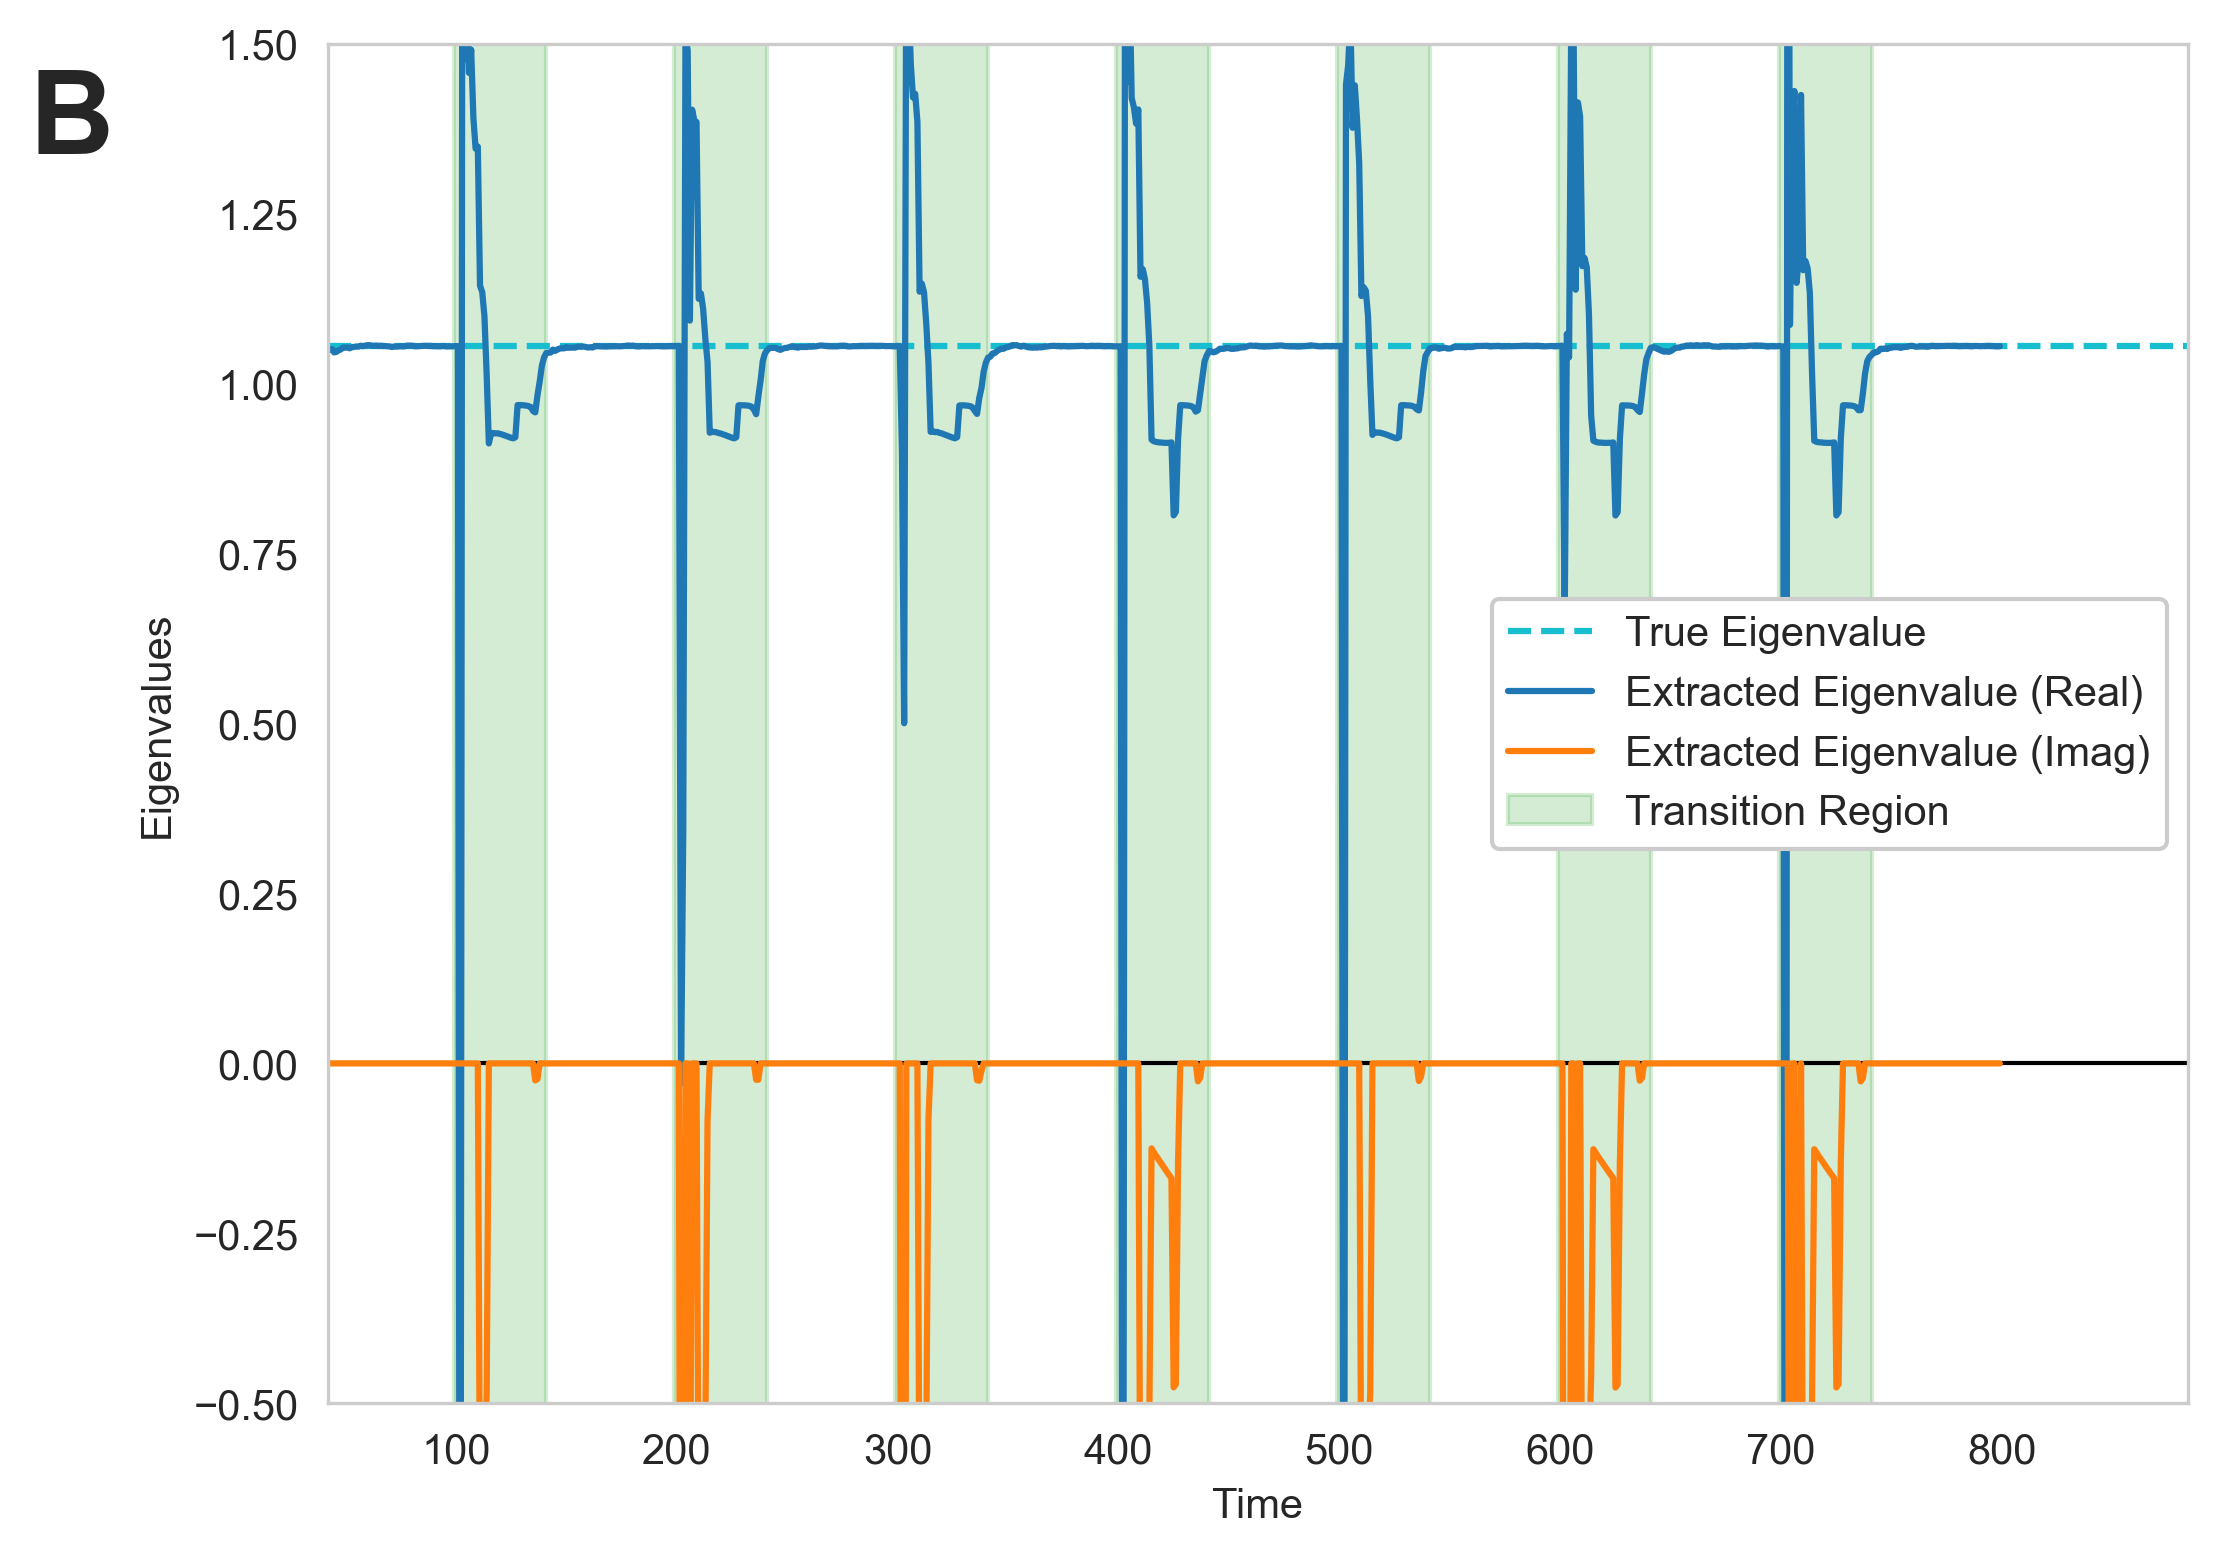

In [19]:
fig, ax = plt.subplots(1, 1)

ax.grid(False)
sns.set_style("whitegrid", {'axes.grid' : False})
# vlines = np.arange(window,0, len(time))
# ax.axvline(len(time)-window, color='r') 
# ax.fill_between([len(time)*1-window-1-2,len(time)*1-2],-100, 100,alpha=0.2, label='Intermediate Region', color='tab:pink')
# [ax.fill_between([len(time)*n-window-n-1,len(time)*n-n-1],-100, 100,alpha=0.2, color='tab:pink') for n in range(2,n_series)]

ax.fill_between([len(time)-2,len(time)-2+window],-10000, 10000,alpha=0.2, label='Transition Region', color='tab:green')
[ax.fill_between([len(time)*n-n-1,len(time)*n-n-1+window],-10000, 10000,alpha=0.2, color='tab:green') for n in range(2,n_series)]
# [ax.axvline(len(time)*n+window-n-1, color='r') for n in range(0,n_series)]
# [ax.axvline(len(time)*n-n-1, color='g') for n in range(1,n_series)]

# [ax.axvline(n*window-dim, color='r') for n in range(1,n_series)]
lam_time = np.arange(window, len(window_ev)+window)
ax.axhline(lams[0],  color='tab:cyan', lw=1.5, linestyle='--', label='True Eigenvalue')
ax.axhline(0, color='black',lw=1.0)
ax.plot(lam_time,window_ev.real, label='Extracted Eigenvalue (Real)')
ax.plot(lam_time, window_ev.imag, label='Extracted Eigenvalue (Imag)')

ax.set_ylabel('Eigenvalues')
ax.set_xlabel('Time')
ax.set_ylim(-0.5,1.5)
ax.set_xlim(window,len(lam_time)+window*3)
plt.legend(loc='center right', framealpha=1.0)

plt.text(-.16, .92, 'B', fontweight='bold', fontsize='28', transform=plt.gca().transAxes)
fig.set_size_inches(8, 6)
plt.show()

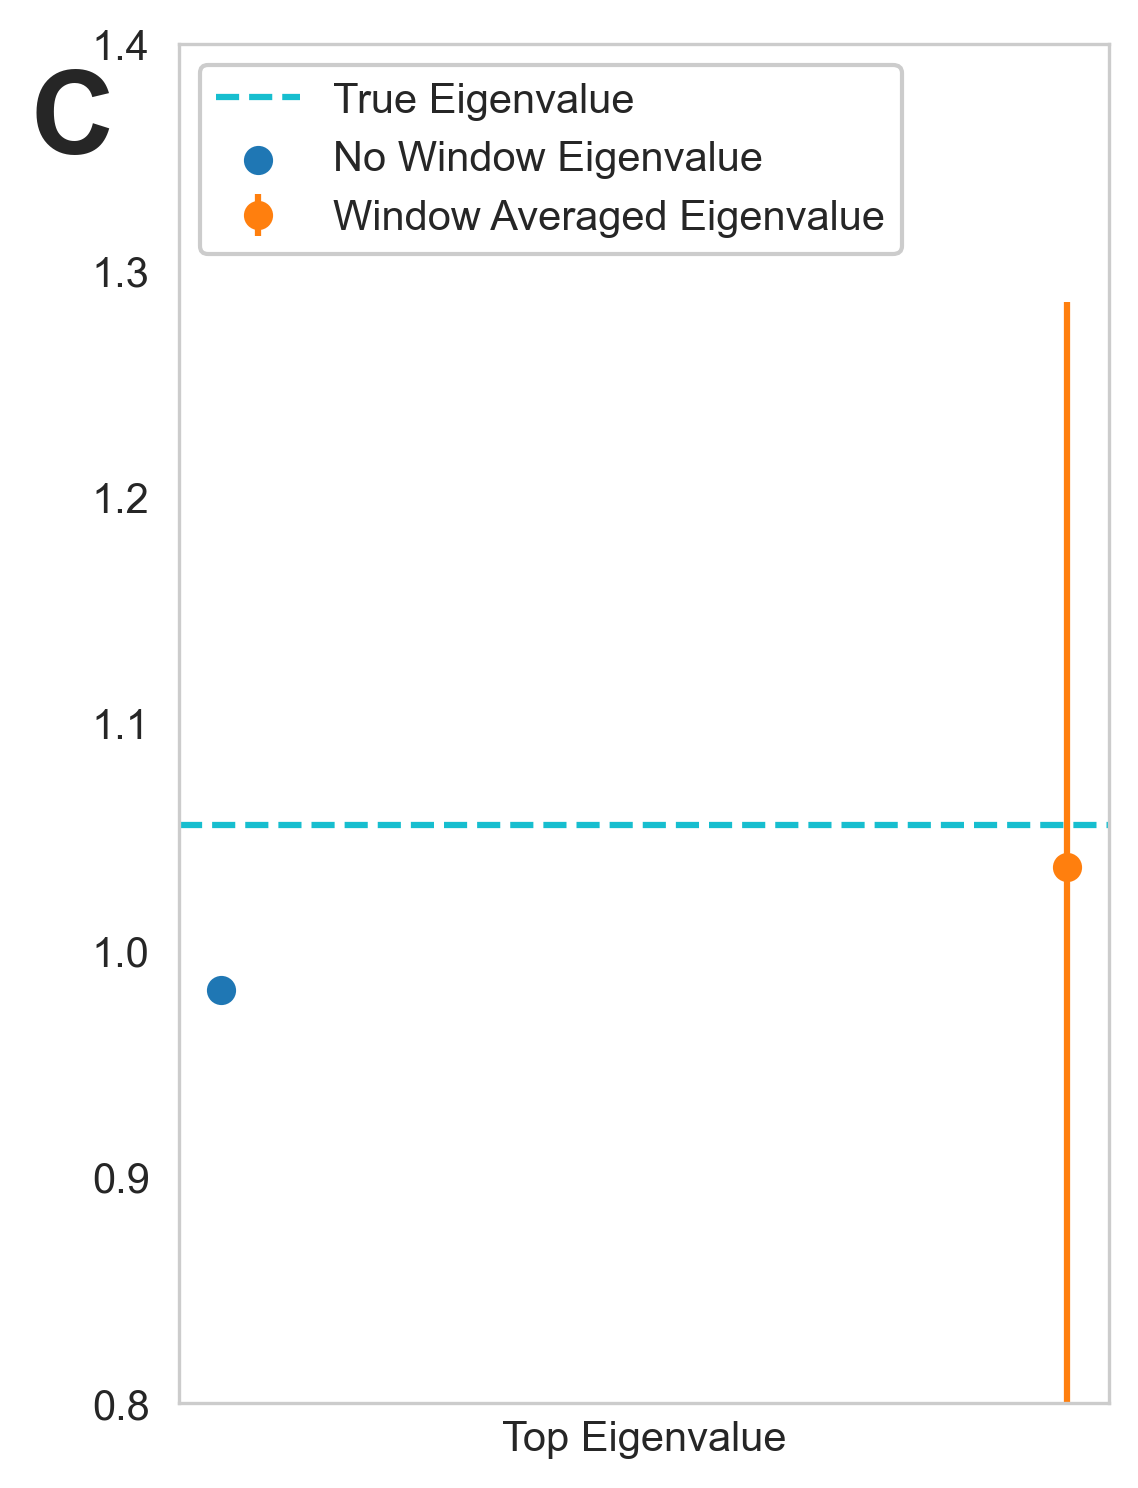

In [20]:
fig, ax = plt.subplots(1, 1)

ax.axhline(true_lam, color='tab:cyan', lw=1.5,
           linestyle='--', label='True Eigenvalue')
ax.scatter(x=0, y=no_window_ev, label='No Window Eigenvalue')
ax.errorbar(x=1, y=np.mean(window_ev.real), yerr=np.std(window_ev.real), fmt='o', color='tab:orange', label='Window Averaged Eigenvalue')
# plt.errorbar(x=2, y=np.mean(window_drop_ev), yerr=np.std(window_drop_ev), fmt='o', color='tab:green', label='Averaged Drop Eigenvalue')
plt.legend(loc='upper left', framealpha=1.0)
ax.set_xticks([])
ax.set_ylim(.8,1.4)
ax.set_xlabel('Top Eigenvalue')
plt.text(-.16, .92, 'C', fontweight='bold', fontsize='28', transform=plt.gca().transAxes)
fig.set_size_inches(4, 6)
plt.show()


/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


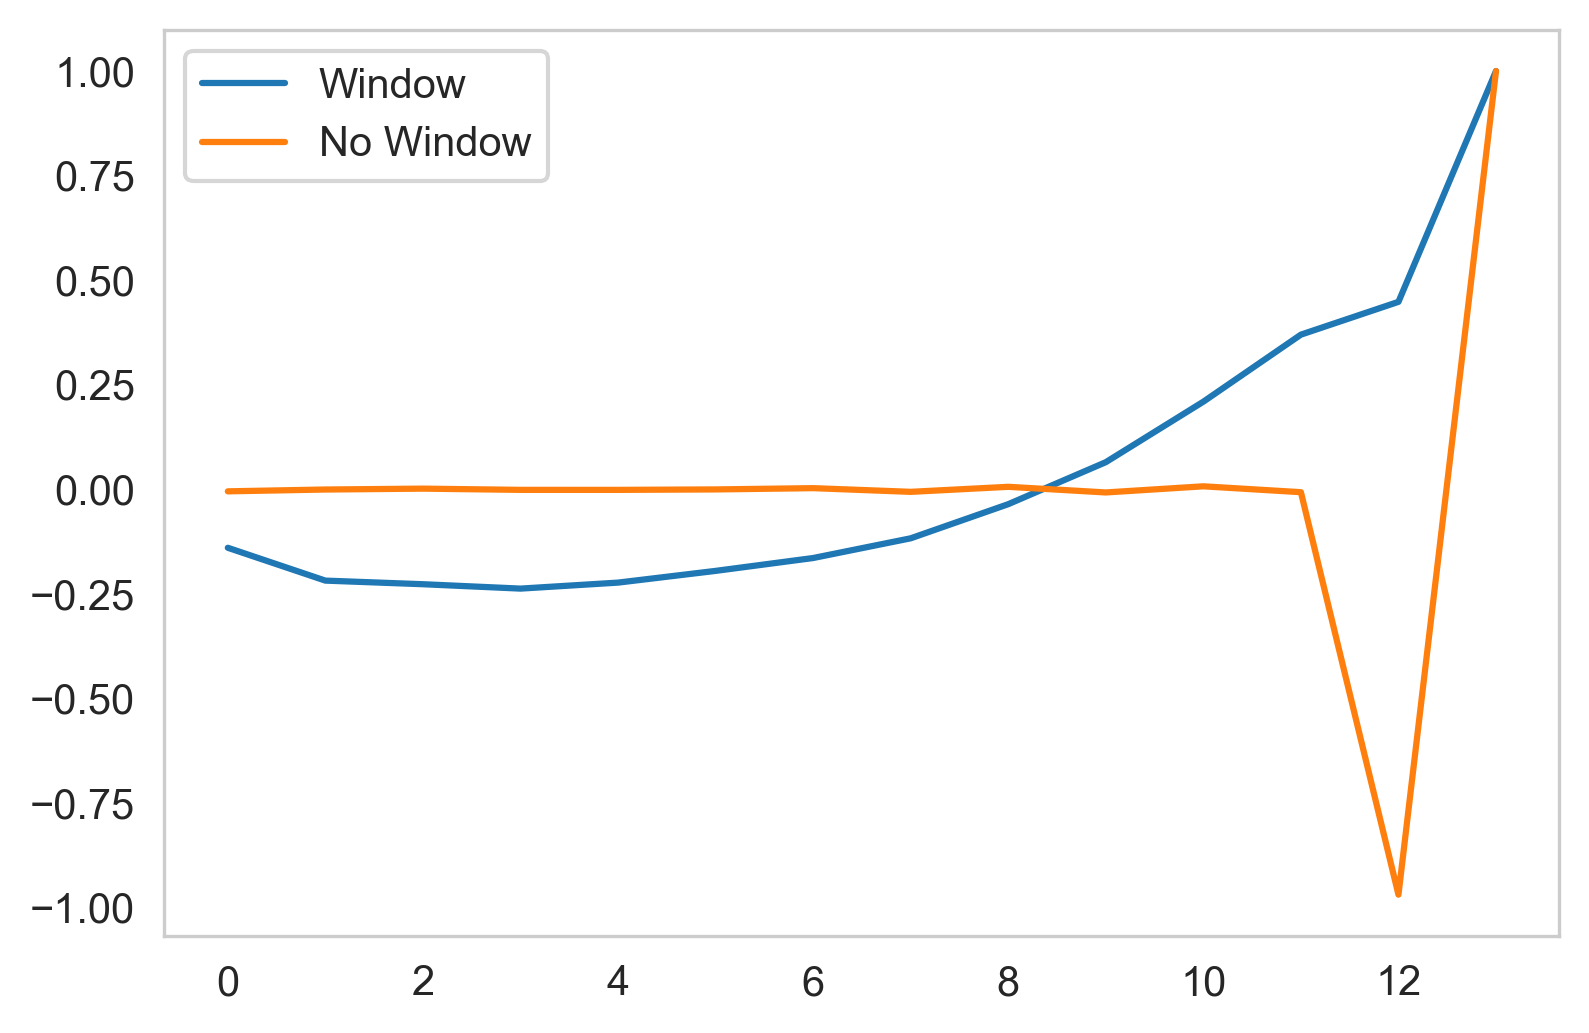

In [7]:
plt.plot(theta_win.real / theta_win[-1].real, label='Window')
plt.plot(theta_nowin.real / theta_nowin[-1], label='No Window')

# plt.title('Filters (REAL)')
plt.legend()
plt.show()

# plt.plot(solve_scale_shift(P_series_nowin, P_series_win), label='No Window')
# plt.plot(P_series_win, label='Window')
# plt.title('P_series NOFIT')
# plt.legend()
# plt.show()

